In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
# import supervised_classification as supc    
from utility_funtions import key_vals2val_keys

Welcome to JupyROOT 6.13/02


In [2]:
from sklearn.externals import joblib

In [3]:
data_snippets_dir = 'trigger_rate_figures_bgf1'
os.makedirs(data_snippets_dir, exist_ok=True)
os.makedirs(os.path.join(data_snippets_dir, 'figures'), exist_ok=True)

In [4]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

In [5]:
common_included_columns_re_list = [
  ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
  
  'gtu_datetime_(mean|min|max)', 'gps_alt_mean', 'gps_lon_mean', 'gps_lat_mean', 
    
  ('^trg(_box_per_gtu|_pmt_per_gtu|_ec_per_gtu)?$', '^(count_nonzero|min|max|sum|mean)$'),
  ('^(bg|orig)(_x_y)?$','^(mean_gz|mean|max|min|sum)$'),
    
#   '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr2_max_clu_major_line_phi',
    
]

In [6]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4.event_trg_box_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4.event_trg_pmt_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4.event_trg_ec_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4.event_gps_lat
	- mean

spb_processing_v4.event_gps_lon
	- mean

spb_processing_v4.event_gps_alt
	- mean

spb_processing_v4.event_gtu_datetime
	- max
	- min
	- mean

spb_processing_v4.event_orig_x_y
	- sum
	- min
	- max
	- mean
	- mean_gz

spb_processing_v4.event_bg_x_y
	- sum
	- min
	- max
	- mean
	- mean_gz

spb_processing_v4.event_trg
	- count_nonzero
	- sum
	- min
	- max
	- mean

spb_processing_v4.event_bg
	- sum
	- min
	- max
	- mean
	- mean_gz

spb_processing_v4.event_orig
	- sum
	- min
	- max
	- mean
	- mean_gz

-----------------------------------------------

In [7]:
flight_df_columns = query_functions_flight.get_dataframe_columns_from_dict(flight_columns_for_analysis_dict)

In [8]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_flight_select_clause_str, unl_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_flight_tables_list)

unl_source_data_type_num = 8

unl_flight_where_clauses_str = ''' 
''' 

unl_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=unl_source_data_type_num,
        select_additional=unl_flight_select_clause_str, 
        join_additional=unl_flight_clauses_str,
        where_additional=unl_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
#         limit=20000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
        limit=500000,
        base_select='')

print(unl_flight_events_selection_query)


    SELECT 
        
        spb_processing_v4.event.event_id, spb_processing_v4.event.source_file_acquisition_full, spb_processing_v4.event.source_file_trigger_full, spb_processing_v4.event.source_file_acquisition, spb_processing_v4.event.source_file_trigger, spb_processing_v4.event.global_gtu, spb_processing_v4.event.packet_id, spb_processing_v4.event.gtu_in_packet, spb_processing_v4.event.num_gtu, spb_processing_v4.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4.event_trg_pmt_per_gtu.min AS trg_pmt_per_gtu_min, spb_processing_v4.event_trg_pmt_per_gtu.sum AS trg_pmt_per_gtu_sum, spb_processing_v4.event_trg_pmt_per_gtu.mean AS trg_pmt_per_gtu_mean, spb_processing_v4.event_trg_ec_per_gtu.max AS t

In [9]:
unl_flight_df = psql.read_sql(unl_flight_events_selection_query, event_v3_storage_provider_flight.connection)
# flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [10]:
len(unl_flight_df)

102794

In [11]:
flight_df_columns

['event_id',
 'source_file_acquisition_full',
 'source_file_trigger_full',
 'source_file_acquisition',
 'source_file_trigger',
 'global_gtu',
 'packet_id',
 'gtu_in_packet',
 'num_gtu',
 'trg_box_per_gtu_max',
 'trg_box_per_gtu_min',
 'trg_box_per_gtu_sum',
 'trg_box_per_gtu_mean',
 'trg_pmt_per_gtu_max',
 'trg_pmt_per_gtu_min',
 'trg_pmt_per_gtu_sum',
 'trg_pmt_per_gtu_mean',
 'trg_ec_per_gtu_max',
 'trg_ec_per_gtu_min',
 'trg_ec_per_gtu_sum',
 'trg_ec_per_gtu_mean',
 'gps_lat_mean',
 'gps_lon_mean',
 'gps_alt_mean',
 'gtu_datetime_max',
 'gtu_datetime_min',
 'gtu_datetime_mean',
 'orig_x_y_sum',
 'orig_x_y_min',
 'orig_x_y_max',
 'orig_x_y_mean',
 'orig_x_y_mean_gz',
 'bg_x_y_sum',
 'bg_x_y_min',
 'bg_x_y_max',
 'bg_x_y_mean',
 'bg_x_y_mean_gz',
 'trg_count_nonzero',
 'trg_sum',
 'trg_min',
 'trg_max',
 'trg_mean',
 'bg_sum',
 'bg_min',
 'bg_max',
 'bg_mean',
 'bg_mean_gz',
 'orig_sum',
 'orig_min',
 'orig_max',
 'orig_mean',
 'orig_mean_gz']

In [12]:
for p in ['global_gtu', 'gtu_in_packet']:
    unl_flight_df['last_trg_' + p] = unl_flight_df[p] - 4 + unl_flight_df['num_gtu'] - 4

In [13]:
unl_flight_df__by_datetime = unl_flight_df.sort_values('gtu_datetime_min', ascending=True)

In [14]:
unl_flight_df__by_datetime.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,bg_max,bg_mean,bg_mean_gz,orig_sum,orig_min,orig_max,orig_mean,orig_mean_gz,last_trg_global_gtu,last_trg_gtu_in_packet
1,36502,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_bgf_1.00.root,40,0,40,9,3.0,...,1,0.000193,1.0,42,0,8,0.002025,1.90909,41,41
10,36511,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_bgf_1.00.root,425,3,41,14,1296.0,...,1,0.000060,1.0,104936,0,45,3.253220,10.32730,431,47
18,36519,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_bgf_1.00.root,441,3,57,14,1296.0,...,1,0.000060,1.0,72233,0,32,2.239370,6.28386,447,63
31,36532,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_bgf_1.00.root,809,6,41,13,1296.0,...,1,0.000072,1.0,104149,0,42,3.477200,9.51306,814,46
49,36550,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_bgf_1.00.root,825,6,57,16,1296.0,...,1,0.000072,1.0,71764,0,26,1.946720,5.83779,833,65


In [15]:
unl_flight_df__by_datetime['gtu_datetime_min'].min() - pd.Timedelta('1 days')

Timestamp('2017-04-23 15:01:46.621045')

In [16]:
unl_flight_df__by_datetime['orig_max'].quantile(q=0.95)

43.0

In [17]:
recreate_plots = True

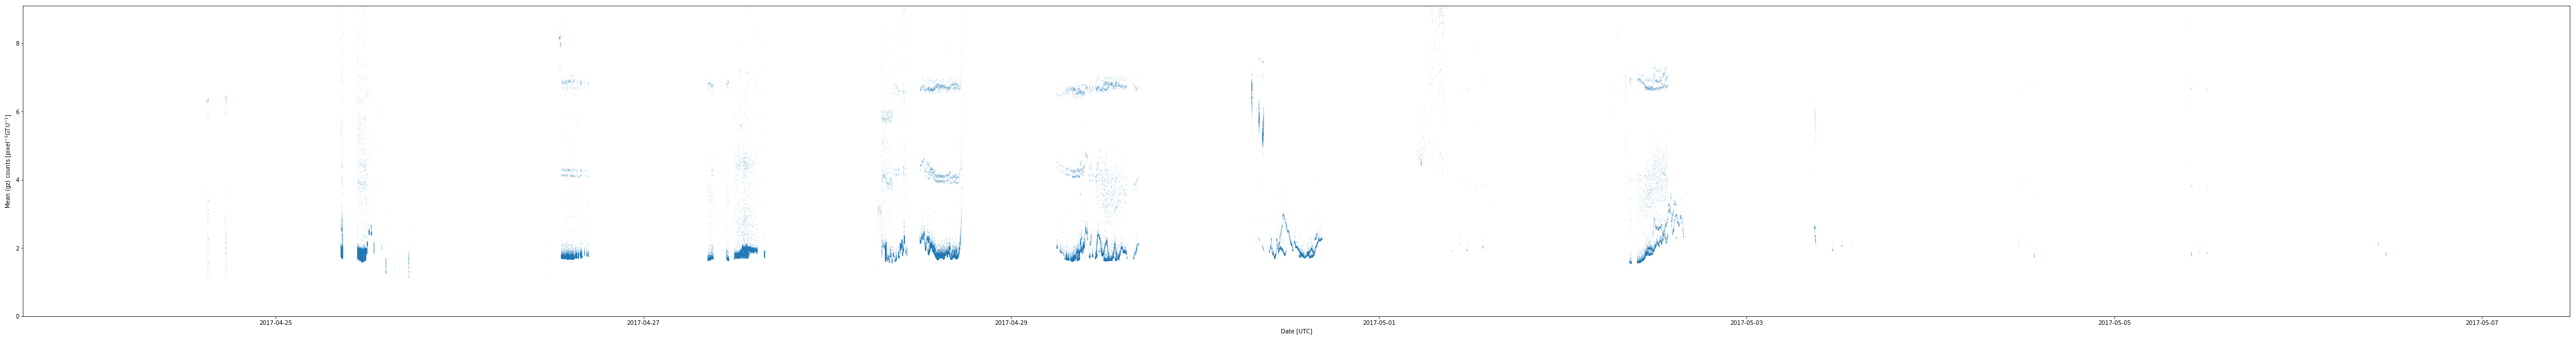

In [18]:
y_prop = 'orig_mean_gz'
y_prop_label = 'Mean (gz) counts [pixel$^{-1}$GTU$^{-1}$]'

plt.figure(figsize=(80, 10))
plt.scatter(unl_flight_df__by_datetime['gtu_datetime_min'].values, 
            unl_flight_df__by_datetime[y_prop].values, 
            s=2, alpha=.8,
#             alpha=.01,
            cmap=plt.get_cmap('plasma'),
            marker='.', edgecolors='none'
           )
plt.xlim(unl_flight_df__by_datetime['gtu_datetime_min'].min() - pd.Timedelta('1 days'), 
         unl_flight_df__by_datetime['gtu_datetime_min'].max() + pd.Timedelta('1 days'))
plt.ylim(0, unl_flight_df__by_datetime[y_prop].quantile(q=0.997))
plt.xlabel('Date [UTC]')
plt.ylabel(y_prop_label)

mean_gz_count_datetime_scatter_80inch_path = \
    os.path.join(data_snippets_dir, 'figures', 'mean_gz_count_datetime_scatter_80inch.png')
if not os.path.exists(mean_gz_count_datetime_scatter_80inch_path) or recreate_plots:
    plt.savefig(mean_gz_count_datetime_scatter_80inch_path, dpi=150)
    
plt.show()

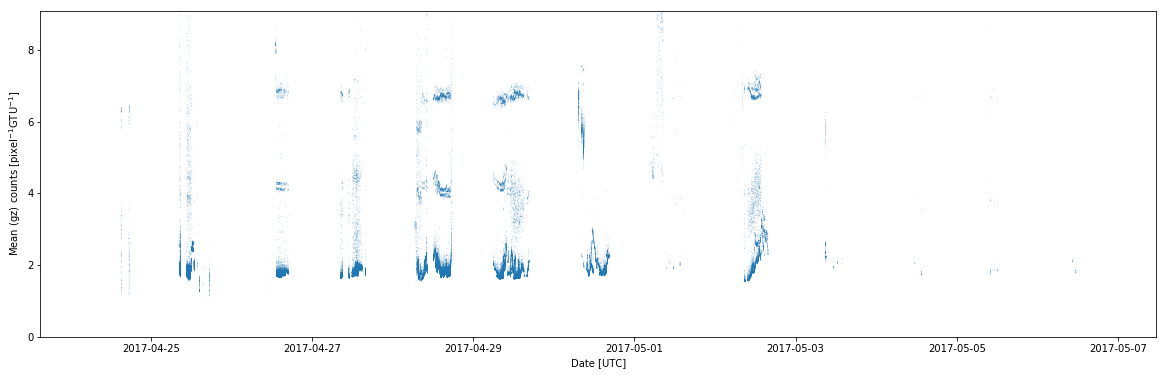

In [19]:
y_prop = 'orig_mean_gz'
y_prop_label = 'Mean (gz) counts [pixel$^{-1}$GTU$^{-1}$]'

plt.figure(figsize=(20, 6))
plt.scatter(unl_flight_df__by_datetime['gtu_datetime_min'].values, 
            unl_flight_df__by_datetime[y_prop].values, 
            s=1, alpha=.8,
#             alpha=.01,
            cmap=plt.get_cmap('plasma'),
            marker='.', edgecolors='none'
           )
plt.xlim(unl_flight_df__by_datetime['gtu_datetime_min'].min() - pd.Timedelta('1 days'), 
         unl_flight_df__by_datetime['gtu_datetime_min'].max() + pd.Timedelta('1 days'))
plt.ylim(0, unl_flight_df__by_datetime[y_prop].quantile(q=0.997))
plt.xlabel('Date [UTC]')
plt.ylabel(y_prop_label)


mean_gz_count_datetime_scatter_20inch_path = \
    os.path.join(data_snippets_dir, 'figures', 'mean_gz_count_datetime_scatter_20inch.png')
if not os.path.exists(mean_gz_count_datetime_scatter_20inch_path) or recreate_plots:
    plt.savefig(mean_gz_count_datetime_scatter_20inch_path, dpi=150)

plt.show()

# First INCORRECT attempt
global_gtu is reset between files

In [20]:
trigger_gaps = []
trigger_gaps_datetimes = []
for i in range(1,len(unl_flight_df__by_datetime)):
    r_i = unl_flight_df__by_datetime.iloc[i]
    r_i_m1 = unl_flight_df__by_datetime.iloc[i-1]
    trigger_gaps.append(r_i['global_gtu'] - r_i_m1['global_gtu'])
    trigger_gaps_datetimes.append(r_i['gtu_datetime_min'])

In [21]:
(unl_flight_df__by_datetime['gtu_datetime_min'].min() - pd.Timedelta('1 days'), 
         unl_flight_df__by_datetime['gtu_datetime_min'].max() + pd.Timedelta('1 days'))

(Timestamp('2017-04-23 15:01:46.621045'),
 Timestamp('2017-05-07 11:27:56.406888'))

In [22]:
trigger_gaps_timestamps = [d.timestamp() for d in trigger_gaps_datetimes]

In [23]:
trigger_gaps_sec = np.array(trigger_gaps) * 2.5 * 1e-6

In [24]:
np.max(trigger_gaps_sec)

0.5825899999999999

In [25]:
trigger_gaps_sec[0:20]

array([ 9.6250e-04,  4.0000e-05,  9.2000e-04,  4.0000e-05,  1.8800e-03,
       -1.9200e-03,  4.0000e-05,  1.2375e-03,  1.9225e-03,  4.0000e-05,
        2.7750e-04,  1.9175e-03,  6.4250e-04,  3.2250e-04,  4.0000e-05,
        5.9500e-04,  1.9250e-03,  4.0000e-05,  5.9500e-04,  9.6750e-04])

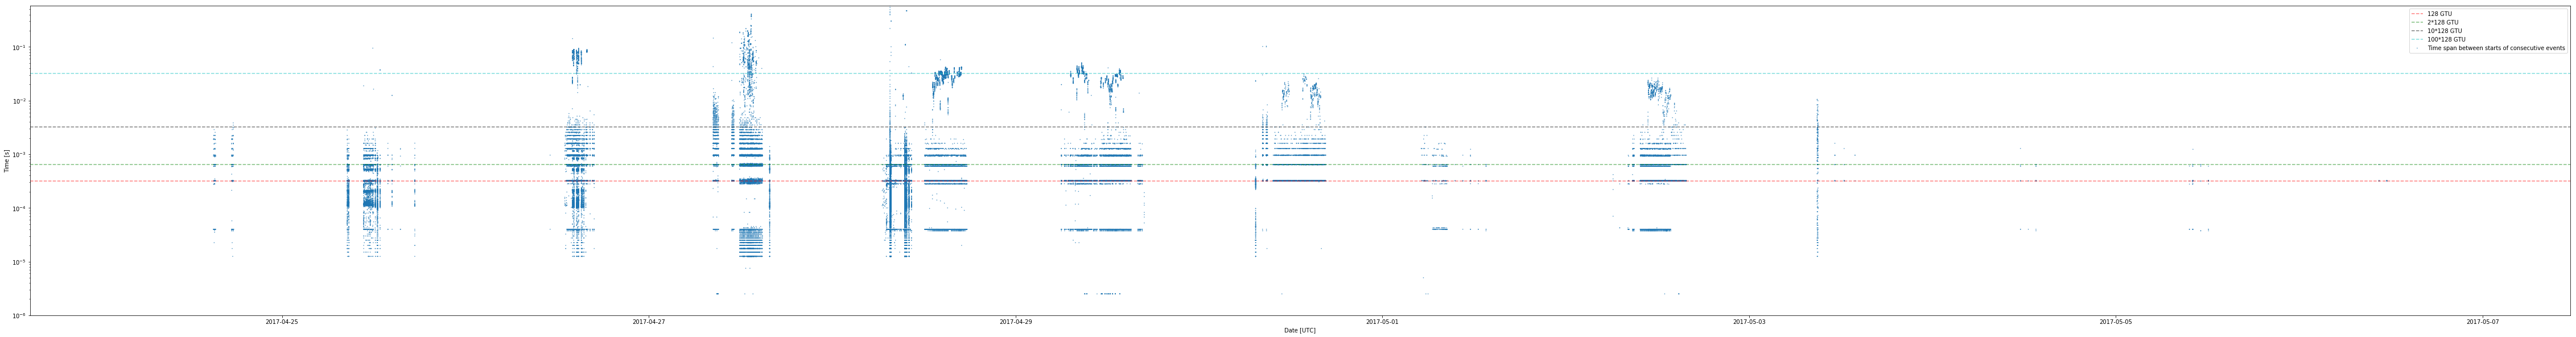

In [26]:

plt_xlim = (np.min(trigger_gaps_datetimes) - pd.Timedelta('1 days'), 
             np.max(trigger_gaps_datetimes) + pd.Timedelta('1 days'))

plt.figure(figsize=(80, 10))
plt.scatter(trigger_gaps_datetimes, 
            trigger_gaps_sec, 
            s=10, alpha=.8,
#             alpha=.01,
            cmap=plt.get_cmap('plasma'),
            marker='.', edgecolors='none',
            label='Time span between starts of consecutive events'
           )
plt.xlim(*plt_xlim)
plt.yscale('log')
plt.ylim(0.000001, np.max(trigger_gaps_sec))
plt.xlabel('Date [UTC]')
plt.ylabel('Time [s]')

plt.plot(plt_xlim, [128*2.5*1e-6]*2, 'r--', alpha=.5, label='128 GTU')
plt.plot(plt_xlim, [2*128*2.5*1e-6]*2, 'g--', alpha=.5, label='2*128 GTU')
plt.plot(plt_xlim, [10*128*2.5*1e-6]*2, 'k--', alpha=.5, label='10*128 GTU')
plt.plot(plt_xlim, [100*128*2.5*1e-6]*2, 'c--', alpha=.5, label='100*128 GTU')
plt.legend()


# mean_gz_count_datetime_scatter_20inch_path = \
#     os.path.join(data_snippets_dir, 'figures', 'mean_gz_count_datetime_scatter_20inch.png')
# if not os.path.exists(mean_gz_count_datetime_scatter_20inch_path) or recreate_plots:
#     plt.savefig(mean_gz_count_datetime_scatter_20inch_path, dpi=150)

plt.show()

This is shows that global_gtu is not consecutive

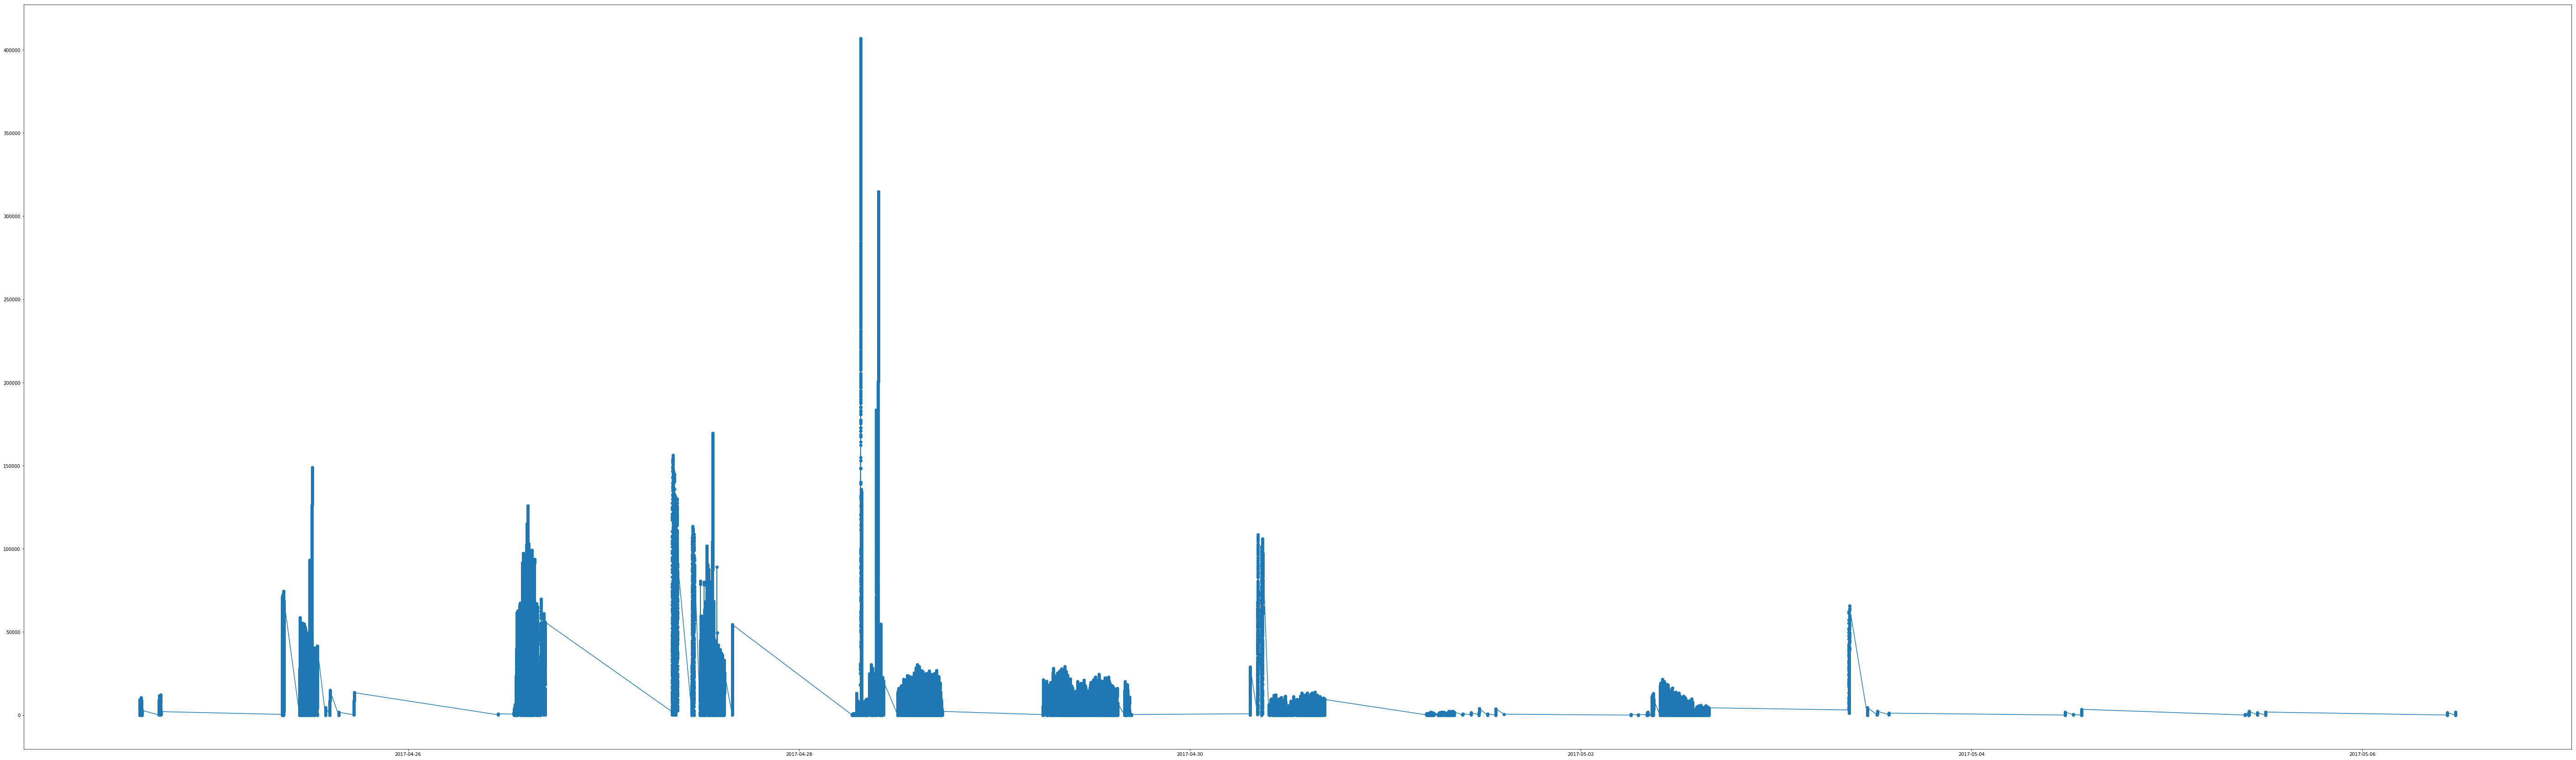

In [27]:
plt.figure(figsize=(100,30))
plt.plot(unl_flight_df__by_datetime['gtu_datetime_min'], unl_flight_df__by_datetime['global_gtu'], 'o-')
plt.show()

# Second attempt

In [28]:
trigger_datetime_gaps = []
trigger_datetime_gaps_datetimes = []
for i in range(1,len(unl_flight_df__by_datetime)):
    r_i = unl_flight_df__by_datetime.iloc[i]
    r_i_m1 = unl_flight_df__by_datetime.iloc[i-1]
    trigger_datetime_gaps.append(r_i['gtu_datetime_min'] - r_i_m1['gtu_datetime_min'])
    trigger_datetime_gaps_datetimes.append(r_i['gtu_datetime_min'])

In [29]:
trigger_datetime_gaps_seconds = [g.total_seconds() for g in trigger_datetime_gaps]

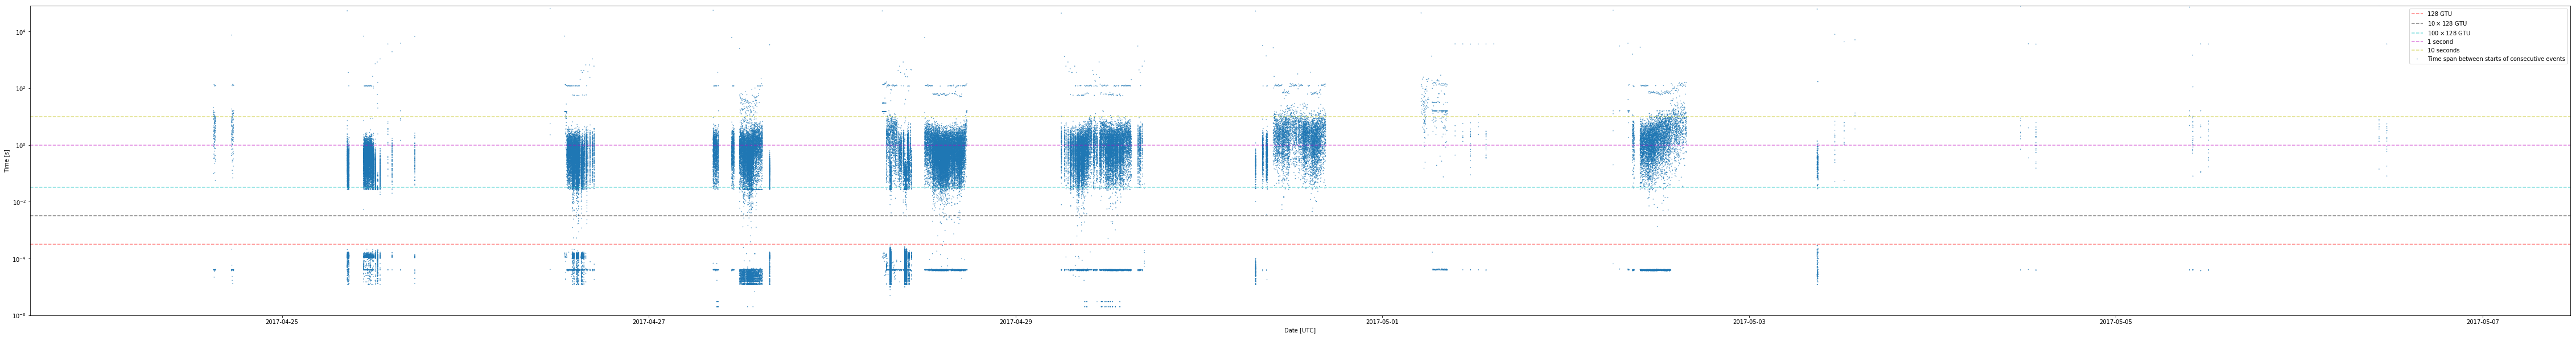

In [30]:
plt_xlim = (np.min(trigger_datetime_gaps_datetimes) - pd.Timedelta('1 days'), 
             np.max(trigger_datetime_gaps_datetimes) + pd.Timedelta('1 days'))

plt.figure(figsize=(80, 10))
plt.scatter(trigger_datetime_gaps_datetimes, 
            trigger_datetime_gaps_seconds, 
            s=10, alpha=.8,
#             alpha=.01,
            cmap=plt.get_cmap('plasma'),
            marker='.', edgecolors='none',
            label='Time span between starts of consecutive events'
           )
plt.xlim(*plt_xlim)
plt.yscale('log')
plt.ylim(0.000001, np.max(trigger_datetime_gaps_seconds))
plt.xlabel('Date [UTC]')
plt.ylabel('Time [s]')

plt.plot(plt_xlim, [128*2.5*1e-6]*2, 'r--', alpha=.5, label='128 GTU')
# plt.plot(plt_xlim, [2*128*2.5*1e-6]*2, 'g--', alpha=.5, label='2*128 GTU')
plt.plot(plt_xlim, [10*128*2.5*1e-6]*2, 'k--', alpha=.5, label=r'$10 \times 128$ GTU')
plt.plot(plt_xlim, [100*128*2.5*1e-6]*2, 'c--', alpha=.5, label=r'$100 \times 128$ GTU')
plt.plot(plt_xlim, [1]*2, 'm--', alpha=.5, label='1 second')
plt.plot(plt_xlim, [10]*2, 'y--', alpha=.5, label='10 seconds')
plt.legend()


time_span_between_events_scatter_80inch = \
    os.path.join(data_snippets_dir, 'figures', 'time_span_between_events_scatter_80inch.png')
if not os.path.exists(time_span_between_events_scatter_80inch) or recreate_plots:
    plt.savefig(time_span_between_events_scatter_80inch, dpi=150)

plt.show()

# Third attempt

In [31]:
recreate_pickles = True

In [32]:
trigger_num_per_step_list = [0]
trigger_datetime_steps_list = []
datetime_step_high = unl_flight_df__by_datetime.iloc[0]['gtu_datetime_min'] + pd.Timedelta('1 second')
max_datetime = unl_flight_df__by_datetime['gtu_datetime_min'].max()

ii = 0
for i, r in unl_flight_df__by_datetime.iterrows():
        
    if r['gtu_datetime_min'] >= datetime_step_high:
        while r['gtu_datetime_min'] >= datetime_step_high:    
            datetime_step_high += pd.Timedelta('1 second')
        trigger_datetime_steps_list.append(datetime_step_high - pd.Timedelta('1 second'))
        trigger_num_per_step_list.append(0)
        ii += 1
        
        if ii % 10000 == 0:
            print('{:<5d}  {} / {}'.format(ii, datetime_step_high, max_datetime))
        
    trigger_num_per_step_list[ii] += 1

trigger_datetime_steps_list.append(datetime_step_high - pd.Timedelta('1 second'))    
    
trigger_num_per_step_list_pathname = \
    os.path.join(data_snippets_dir, 'trigger_num_per_step.pkl')
trigger_datetime_steps_list_pathname = \
    os.path.join(data_snippets_dir, 'trigger_datetime_steps.pkl')

if not os.path.exists(trigger_num_per_step_list_pathname) or not os.path.exists(trigger_datetime_steps_list_pathname) \
        or recreate_pickles:
    joblib.dump(trigger_num_per_step_list, trigger_num_per_step_list_pathname)
    joblib.dump(trigger_datetime_steps_list, trigger_datetime_steps_list_pathname)

10000  2017-04-27 12:45:48.621045 / 2017-05-06 11:27:56.406888
20000  2017-04-28 14:52:24.621045 / 2017-05-06 11:27:56.406888
30000  2017-04-29 12:05:25.621045 / 2017-05-06 11:27:56.406888
40000  2017-05-02 09:46:07.621045 / 2017-05-06 11:27:56.406888


In [33]:
print(unl_flight_df__by_datetime['gtu_datetime_min'].min())
print(unl_flight_df__by_datetime['gtu_datetime_min'].max())

2017-04-24 15:01:46.621045
2017-05-06 11:27:56.406888


In [35]:
print(min(trigger_datetime_steps_list))
print(max(trigger_datetime_steps_list))

2017-04-24 15:01:54.621045
2017-05-06 11:27:55.621045


In [36]:
len(trigger_num_per_step_list)

44497

In [37]:
len(trigger_datetime_steps_list)

44497

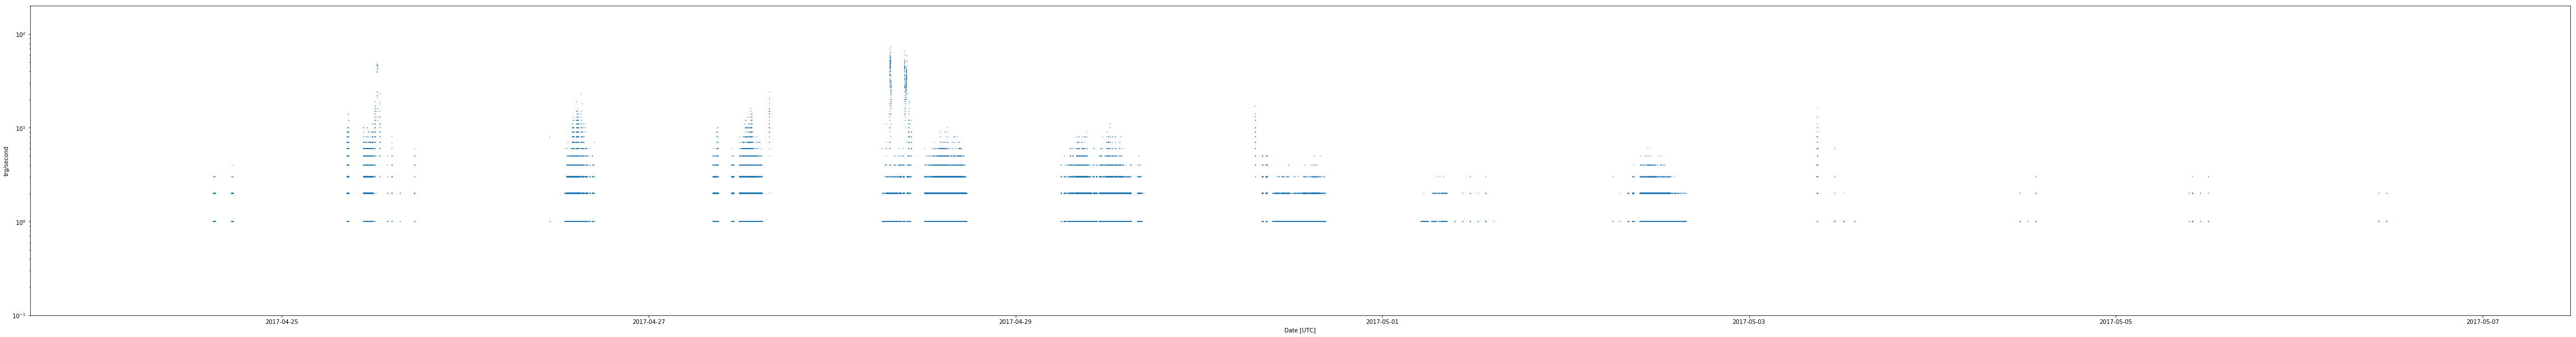

In [38]:
plt_xlim = (np.min(trigger_datetime_steps_list) - pd.Timedelta('1 days'), 
             np.max(trigger_datetime_steps_list) + pd.Timedelta('1 days'))

plt.figure(figsize=(80, 10))
plt.scatter(trigger_datetime_steps_list, 
            trigger_num_per_step_list, 
            s=10, alpha=.8,
#             alpha=.01,
            cmap=plt.get_cmap('plasma'),
            marker='.', edgecolors='none',
            label='Num triggers per second'
           )
plt.xlim(*plt_xlim)
plt.yscale('log')
# plt.ylim(np.min(trigger_num_per_step), np.max(trigger_num_per_step))
plt.ylim(1e-1, 200)
plt.xlabel('Date [UTC]')
plt.ylabel('trg/second')

# plt.plot(plt_xlim, [128*2.5*1e-6]*2, 'r--', alpha=.5, label='128 GTU')
# # plt.plot(plt_xlim, [2*128*2.5*1e-6]*2, 'g--', alpha=.5, label='2*128 GTU')
# plt.plot(plt_xlim, [10*128*2.5*1e-6]*2, 'k--', alpha=.5, label=r'$10 \times 128$ GTU')
# plt.plot(plt_xlim, [100*128*2.5*1e-6]*2, 'c--', alpha=.5, label=r'$100 \times 128$ GTU')
# plt.plot(plt_xlim, [1]*2, 'm--', alpha=.5, label='1 second')
# plt.plot(plt_xlim, [10]*2, 'y--', alpha=.5, label='10 seconds')
# plt.legend()


trigger_num_per_second_scatter_80inch = \
    os.path.join(data_snippets_dir, 'figures', 'trigger_num_per_second_scatter_80inch.png')
if not os.path.exists(trigger_num_per_second_scatter_80inch) or recreate_plots:
    plt.savefig(trigger_num_per_second_scatter_80inch, dpi=150)

plt.show()

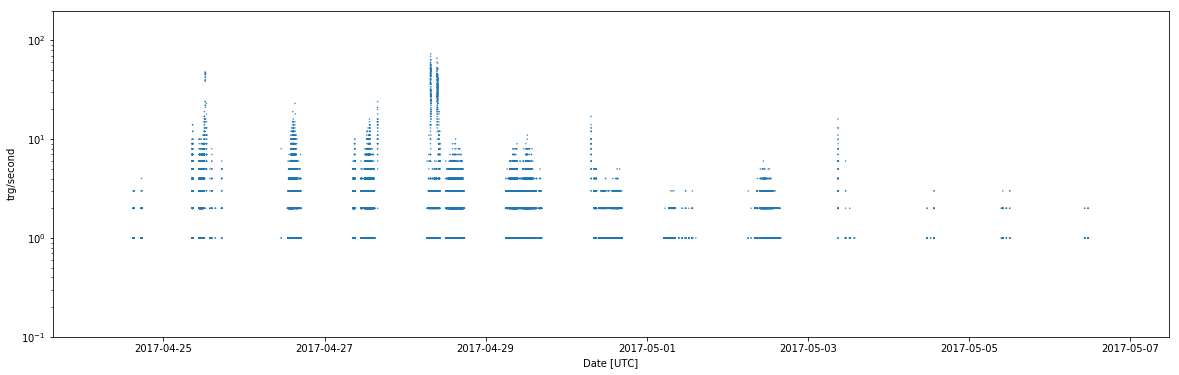

In [39]:
plt_xlim = (np.min(trigger_datetime_steps_list) - pd.Timedelta('1 days'), 
             np.max(trigger_datetime_steps_list) + pd.Timedelta('1 days'))

plt.figure(figsize=(20, 6))
plt.scatter(trigger_datetime_steps_list, 
            trigger_num_per_step_list, 
            s=10, alpha=.8,
#             alpha=.01,
            cmap=plt.get_cmap('plasma'),
            marker='.', edgecolors='none',
            label='Num triggers per second'
           )
plt.xlim(*plt_xlim)
plt.yscale('log')
# plt.ylim(np.min(trigger_num_per_step), np.max(trigger_num_per_step))
plt.ylim(1e-1, 200)
plt.xlabel('Date [UTC]')
plt.ylabel('trg/second')

# plt.plot(plt_xlim, [128*2.5*1e-6]*2, 'r--', alpha=.5, label='128 GTU')
# # plt.plot(plt_xlim, [2*128*2.5*1e-6]*2, 'g--', alpha=.5, label='2*128 GTU')
# plt.plot(plt_xlim, [10*128*2.5*1e-6]*2, 'k--', alpha=.5, label=r'$10 \times 128$ GTU')
# plt.plot(plt_xlim, [100*128*2.5*1e-6]*2, 'c--', alpha=.5, label=r'$100 \times 128$ GTU')
# plt.plot(plt_xlim, [1]*2, 'm--', alpha=.5, label='1 second')
# plt.plot(plt_xlim, [10]*2, 'y--', alpha=.5, label='10 seconds')
# plt.legend()


trigger_num_per_second_scatter_20inch_pathname = \
    os.path.join(data_snippets_dir, 'figures', 'trigger_num_per_second_scatter_20inch.png')
if not os.path.exists(trigger_num_per_second_scatter_20inch_pathname) or recreate_plots:
    plt.savefig(trigger_num_per_second_scatter_20inch_pathname, dpi=150)

plt.show()

In [40]:
import datetime

In [41]:
step_timedelta = datetime.timedelta(seconds=120)

avg_trigger_num_per_step_list = []
avg_trigger_datetime_steps_list = []
# avg_trigger_p_r_steps_list = []

datetime_step_high = trigger_datetime_steps_list[0] + step_timedelta

last_datetime_step_start = trigger_datetime_steps_list[0]
sum_trigger_num_per_step = 0


for i, (cur_trigger_num_per_step, cur_trigger_datetime_step) in \
        enumerate(zip(trigger_num_per_step_list, trigger_datetime_steps_list)):
    
#     if i > 9600:
#         print('{:<5d} ; ({:3}, {:20}, {:10}) ; {:20} ; {:20}'.format(
#             i, cur_trigger_num_per_step, str(cur_trigger_datetime_step), str(cur_trigger_p_r_step), 
#             str(datetime_step_high), str(last_datetime_step_start)))
    
    
#     if i > 9700:
#         break
    
    if cur_trigger_datetime_step >= datetime_step_high:
        
#         if i > 9600:
#             print('   !!!!!!!!')
        
        avg_trigger_num_per_step_list.append(sum_trigger_num_per_step / (datetime_step_high - last_datetime_step_start).total_seconds())
        avg_trigger_datetime_steps_list.append(last_datetime_step_start)
            
        last_datetime_step_start = cur_trigger_datetime_step # was datetime_step_high
            
        while cur_trigger_datetime_step >= datetime_step_high:
            datetime_step_high += step_timedelta
        
        sum_trigger_num_per_step = 0

    # endif
    
#     print('  {:<5d}     {}  <  {}'.format(ii, gtu_pdm_data.gtu_datetime, datetime_step_high))

    sum_trigger_num_per_step += cur_trigger_num_per_step

    #trigger_num_per_step[ii] += 1
    
# endfor

avg_trigger_num_per_step_list.append(sum_trigger_num_per_step / (datetime_step_high - last_datetime_step_start).total_seconds())
avg_trigger_datetime_steps_list.append(last_datetime_step_start)


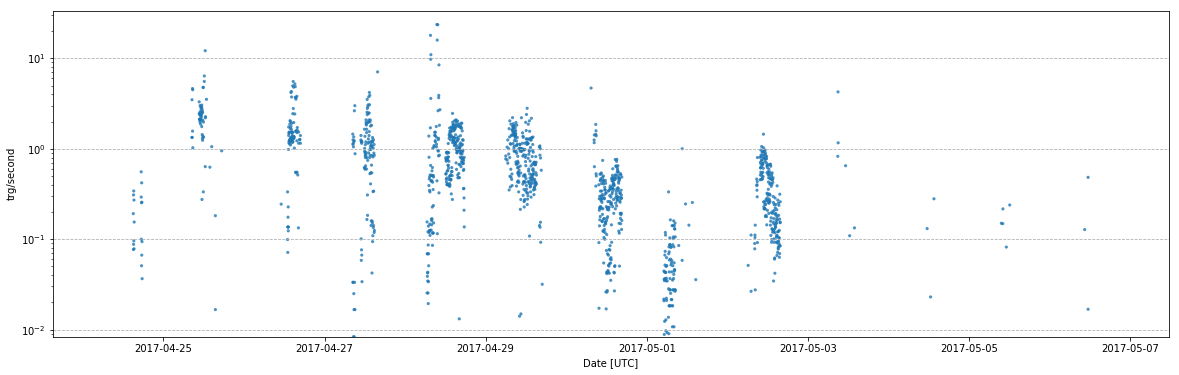

In [43]:
plt_xlim = (np.min(avg_trigger_datetime_steps_list) - datetime.timedelta(days=1), 
             np.max(avg_trigger_datetime_steps_list) + datetime.timedelta(days=1))

plt.figure(figsize=(20, 6))
plt.scatter(avg_trigger_datetime_steps_list, 
            avg_trigger_num_per_step_list, 
            s=10, alpha=.8,
#             alpha=.01,
            cmap=plt.get_cmap('plasma'),
            marker='o', edgecolors='none',
            label='Num triggers per second'
           )
plt.xlim(*plt_xlim)
plt.yscale('log')
# plt.ylim(1e-1, np.max(trigger_num_per_step)+10)
plt.ylim(np.min(avg_trigger_num_per_step_list), np.max(avg_trigger_num_per_step_list)+10)
plt.xlabel('Date [UTC]')
plt.ylabel('trg/second')
plt.gca().grid(which='major', axis='y', linestyle='--')

trigger_rate_v1_scatter_20inch_pathname = \
    os.path.join(data_snippets_dir, 'figures', 'trigger_rate_v1_scatter_20inch.png')
if not os.path.exists(trigger_num_per_second_scatter_20inch_pathname) or recreate_plots:
    plt.savefig(trigger_rate_v1_scatter_20inch_pathname, dpi=150)

plt.show()